#Importing libraries and dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import keras.backend as K
import warnings
from sklearn.utils import compute_class_weight
import pywt

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unrar
!unrar x /content/drive/MyDrive/Covid_mrinal/CovidXRay.rar

Streaming output truncated to the last 5000 lines.
Extracting  Chest X-Ray image dataset/Normal/Normal-6710.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6711.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6712.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6713.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6714.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6715.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6716.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6717.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6718.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6719.png              75%  OK 
Extracting  Chest X-Ray image

#Loading main dataset

In [ ]:
images = []
classes_labels = []
for i in os.listdir("/content/Chest X-Ray image dataset"):
  class_path = f"/content/Chest X-Ray image dataset/{i}"
  for j in os.listdir(class_path):
    file_path = f"{class_path}/{j}"
    classes_labels.append(i)
    images.append(cv2.resize(cv2.imread(file_path, 1), (224, 224)))

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images, classes_labels, test_size = 0.2, random_state = 42)

In [ ]:
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

In [ ]:
len(train_images)

16932

#Upsampling dataset

In [ ]:
covid = []
lung_opacity = []
normal = []
viral_pneumonia = []
for i,j in list(zip(train_images, train_labels)):
  if j == "COVID":
    covid.append(i)
  elif j == "Lung opacity":
    lung_opacity.append(i)
  elif j == "Normal":
    normal.append(i)
  elif j == "Viral Pneumonia":
    viral_pneumonia.append(i)

In [ ]:
covid = np.asarray(covid)
lung_opacity = np.asarray(lung_opacity)
normal = np.asarray(normal)
viral_pneumonia = np.asarray(viral_pneumonia)

In [ ]:
print(f"COVID : {covid.shape}\tLung Opacity : {lung_opacity.shape}\tNormal : {normal.shape}\tViral Pneumonia : {viral_pneumonia.shape}")

COVID : (2923, 224, 224, 3)	Lung Opacity : (4831, 224, 224, 3)	Normal : (8096, 224, 224, 3)	Viral Pneumonia : (1082, 224, 224, 3)


In [ ]:
covid_selected = covid
lung_opacity_selected = lung_opacity[np.random.choice(lung_opacity.shape[0], size=lung_opacity.shape[0] - 1000)]
normal_selected = normal[np.random.choice(normal.shape[0], size=normal.shape[0] - 4000)]
viral_pneumonia_selected = viral_pneumonia

In [ ]:
print(f"COVID : {covid_selected.shape}\tLung Opacity : {lung_opacity_selected.shape}\tNormal : {normal_selected.shape}\tViral Pneumonia : {viral_pneumonia_selected.shape}")

COVID : (2923, 224, 224, 3)	Lung Opacity : (3831, 224, 224, 3)	Normal : (4096, 224, 224, 3)	Viral Pneumonia : (1082, 224, 224, 3)


In [ ]:
del covid, lung_opacity, normal, viral_pneumonia

In [ ]:
def clahe(image,cliplimit,gridsize):

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(gridsize,gridsize))
    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    bgr = bgr.astype(np.float32)/255
    return bgr

In [ ]:
def claheInt(image,cliplimit,gridsize):

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(gridsize,gridsize))
    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    # bgr = bgr.astype('float32')/255
    return bgr

In [ ]:
def svdstdwithoutdecompostionC(imageA):
  image = imageA
  image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
  target_im = cv2.imread('/content/Chest X-Ray image dataset/COVID/COVID-32.png')
  target_im = cv2.cvtColor(target_im, cv2.COLOR_RGB2GRAY)
  st = np.std(image)
  st1 = np.std(target_im)
  mean  =np.mean(image)
  mean1 = np.mean(target_im)
  c = st/mean
  c1 = st1/mean1
  if c1 > c:
    ratio = 1.05 + ((c1-c)/(c1+c))
  else:
  #  print("Original image contrast is better than the target image")
   ratio = 1.05
  u1, s1, v1 = np.linalg.svd(target_im)
  u2, s2, v2 = np.linalg.svd(image)
  s2_new= ratio * s2
  cmpimg = np.matrix(u2[:,:],dtype=np.float32) * np.diag(s2_new[:]) * np.matrix(v2[:,:],dtype=np.float32)
  final_img = cmpimg
  final_img = np.array(final_img, dtype=np.float32)
  # cv2_imshow(final_img)
  final_img  = cv2.cvtColor(final_img, cv2.COLOR_GRAY2RGB) / 255
  final_img = NormalizeData(final_img)
  # final_img = final_img.astype(dtype=np.float16)/255
  return final_img

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

##Upsampling COVID

In [ ]:
# test_images = test_images.astype(np.float32) / 255

In [ ]:
covid_clahe_point_5 = [clahe(x, 0.5, 8) for x in covid_selected]
covid_preprocessed_custom = [svdstdwithoutdecompostionC(x) for x in covid_selected]

In [ ]:
covid_clahe_point_5 = np.array(covid_clahe_point_5)
covid_preprocessed_custom = np.array(covid_preprocessed_custom)

In [ ]:
covid_clahe_point_5 = covid_clahe_point_5[np.random.choice(covid_clahe_point_5.shape[0], size=covid_clahe_point_5.shape[0] - 52)]
covid_preprocessed_custom = covid_preprocessed_custom[np.random.choice(covid_preprocessed_custom.shape[0], size=covid_preprocessed_custom.shape[0] - 52)]
covid_selected = covid_selected[np.random.choice(covid_selected.shape[0], size=covid_selected.shape[0] - 53)]

In [ ]:
np.random.choice()

In [ ]:
covid_final = []
for i in covid_clahe_point_5:
  covid_final.append(i)
for i in covid_preprocessed_custom:
  covid_final.append(i)
for i in covid_selected:
  covid_final.append(i.astype(np.float32)/255)

In [ ]:
len(covid_clahe_point_5), len(covid_preprocessed_custom), len(covid_selected)

(2871, 2871, 2870)

In [ ]:
sum([len(covid_clahe_point_5), len(covid_preprocessed_custom), len(covid_selected)])

8612

In [ ]:
from PIL import Image


In [ ]:
for index, i in enumerate(covid_final):
  im = Image.fromarray(i)
  im.save(f"/content/drive/MyDrive/Covid_mrinal/Mathematical Preprocessed/{index}.png")
  print(i)

array([[[0.39215687, 0.39215687, 0.39215687],
        [0.37254903, 0.37254903, 0.37254903],
        [0.3529412 , 0.3529412 , 0.3529412 ],
        ...,
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314]],

       [[0.2627451 , 0.2627451 , 0.2627451 ],
        [0.24705882, 0.24705882, 0.24705882],
        [0.23137255, 0.23137255, 0.23137255],
        ...,
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314]],

       [[0.13725491, 0.13725491, 0.13725491],
        [0.12156863, 0.12156863, 0.12156863],
        [0.10196079, 0.10196079, 0.10196079],
        ...,
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314]],

       ...,

       [[0.46666667, 0.46666667, 0.46666667],
        [0.05490196, 0.05490196, 0.05490196],
        [0.00784314, 0

##Upsampling Viral Pneumonia

In [ ]:
viral_pneumonia_clahe_point_5 = [clahe(x, 0.5, 8) for x in viral_pneumonia_selected]
viral_pneumonia_clahe_1 = [clahe(x, 1, 8) for x in viral_pneumonia_selected]
viral_pneumonia_preprocessed_custom = [svdstdwithoutdecompostionC(x) for x in viral_pneumonia_selected]

In [ ]:
viral_pneumonia_preprocessed_custom_with_clahe_point_5 = [svdstdwithoutdecompostionC(claheInt(x, 0.5, 8)) for x in viral_pneumonia_selected]

In [ ]:
covid_final = []
for i in covid_clahe_point_5:
  covid_final.append(i)
for i in covid_preprocessed_custom:
  covid_final.append(i)
# for i in covid_selected:
#   covid_final.append(i.astype(np.float16)/255)

viral_pneumonia_final = []
for i in viral_pneumonia_clahe_point_5:
  viral_pneumonia_final.append(i)
for i in viral_pneumonia_clahe_1:
  viral_pneumonia_final.append(i)
for i in viral_pneumonia_preprocessed_custom:
  viral_pneumonia_final.append(i)
for i in viral_pneumonia_preprocessed_custom_with_clahe_point_5:
  viral_pneumonia_final.append(i)
# for i in viral_pneumonia_selected:
#   viral_pneumonia_final.append(i.astype(np.float16)/255)

In [ ]:
del covid_selected, viral_pneumonia_selected, covid_clahe_point_5, covid_preprocessed_custom, viral_pneumonia_clahe_point_5, viral_pneumonia_clahe_1, viral_pneumonia_preprocessed_custom, viral_pneumonia_preprocessed_custom_with_clahe_point_5

In [ ]:
lung_opacity_inter = [clahe(x, 0.5, 8) for x in lung_opacity_selected]
normal_inter = [clahe(x, 0.5, 8) for x in normal_selected]

In [ ]:
lung_opacity_final = []
# for i in lung_opacity_selected:
#   lung_opacity_final.append(i.astype(np.float16)/255)
for i in lung_opacity_inter:
  lung_opacity_final.append(i)

In [ ]:
del lung_opacity_selected, lung_opacity_inter

In [ ]:
X_train = []
Y_train = []
for i in covid_final:
  X_train.append(i)
  Y_train.append("COVID")
for i in lung_opacity_final:
  X_train.append(i)
  Y_train.append("Lung opacity")
for i in viral_pneumonia_final:
  X_train.append(i)
  Y_train.append("Viral Pneumonia")

In [ ]:
del covid_final, lung_opacity_final, viral_pneumonia_final

In [ ]:
normal_final = []
# for i in normal_selected:
#   normal_final.append(i.astype(np.float16)/255)
for i in normal_inter:
  normal_final.append(i)

In [ ]:
for i in normal_final:
  X_train.append(i)
  Y_train.append("Normal")

In [ ]:
del normal_selected, normal_inter, normal_final

In [ ]:
len(X_train)

18011

In [ ]:
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)

In [ ]:
import pickle 
pickle.dump(lb, open('binarizer.pkl', 'wb'))

In [ ]:
del lb

In [ ]:
X_train = np.array(X_train, dtype=np.float16)

In [ ]:
X_train.shape

(18011, 224, 224, 3)

#Data Visualization

In [ ]:
def data(history):
  return pd.DataFrame(data=list(zip(history.history["accuracy"], history.history["val_accuracy"], history.history["loss"], history.history["val_loss"], history.history["recall"], history.history["val_recall"], history.history["precision"], history.history["val_precision"], history.history["auc"], history.history["val_auc"], history.history["specificity"], history.history["val_specificity"], history.history["sensitivity"], history.history["val_sensitivity"], history.history["mcc"], history.history["val_mcc"])) , columns=["Accuracy", "Validation Accuracy", "Loss", "Validation Loss", "Recall", "Validation Recall", "Precision", "Validation Precision", "AUC", "Validation AUC", "Specificity", "Validation Specificity" ,"Sensitivity", "Validation Sensitivity", "MCC", "Validation MCC"])

In [ ]:
def history_visualization(df):
  sns.set_style('darkgrid')
  nrow = 4
  ncol = 2
  df_columns = df.columns
  df_list = [df[col] for col in df]
  titles=["Accuracy Visualization", "Loss Visualization", "Recall Visualization", "Precision Visualization", "AUC Visualization", "Specificity Visualization", "Sensitivity Visualization", "MCC Visualization"]
  fig, axes = plt.subplots(nrow, ncol, figsize=(20, 16))
  count = 0
  i = 0
  for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c], x="Number of Epochs", legend="brief", label=df_columns[count], marker="o").set_title(titles[i])
        df_list[count+1].plot(ax=axes[r, c], x="Number of Epochs", legend="brief" ,label=df_columns[count+1], marker="o").set_title(titles[i])
        i+=1
        count+=2

In [ ]:
early_stoping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

#Custom Metrics using Tensorflow

In [ ]:
def true_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.linalg.diag_part(res), axis = 0)

def false_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def false_negative(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def true_negative(y_true, y_pred):
  y_true_res = tf.argmax(y_true)
  y_pred_res = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true_res, y_pred_res, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1), axis=0) - (false_negative(y_true, y_pred) + false_positive(y_true, y_pred) + true_positive(y_true, y_pred))

In [ ]:
def sensitivity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TP)
    den = float(TP + FN + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

def specificity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TN)
    den = float(TN + FP + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

In [ ]:
def mcc(y_true, y_pred):
  y_true = tf.argmax(y_true).numpy()
  y_pred = tf.argmax(y_pred).numpy()

  return tf.constant(matthews_corrcoef(y_true, y_pred))

#Image Generator

In [ ]:
image_generator = ImageDataGenerator(validation_split = 0.2)

In [ ]:
train_dataset = image_generator.flow_from_directory(directory="/content/drive/MyDrive/Covid_mrinal/Preprocessed", target_size=(224, 224), color_mode="rgb", class_mode="categorical", shuffle=True, subset="training")

Found 24000 images belonging to 4 classes.


In [ ]:
validation_dataset = image_generator.flow_from_directory(directory="/content/drive/MyDrive/Covid_mrinal/Preprocessed", target_size=(224, 224), color_mode="rgb", class_mode="categorical", shuffle=True, subset="validation")

Found 5998 images belonging to 4 classes.


#ResNet50 without class weights



In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model_resnet50 = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model_resnet50.trainable = False
# base_model_resnet50.summary()
final_model_resnet50 = keras.models.Sequential([base_model_resnet50, keras.layers.Flatten(), keras.layers.Dense(4, activation="softmax")])
final_model_resnet50.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
resnet50_history = final_model_resnet50.fit(x=train_dataset, validation_data=validation_dataset, epochs=20, batch_size=32, callbacks=[early_stoping])

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/20
750/750 [==============================] - 8165s 11s/step - loss: 1.9432 - accuracy: 0.5447 - precision: 0.8965 - recall: 0.8963 - auc: 0.9460 - specificity: 0.7820 - sensitivity: 0.5527 - mcc: 0.7617 - val_loss: 2.1680 - val_accuracy: 0.6936 - val_precision: 0.9193 - val_recall: 0.9193 - val_auc: 0.9541 - val_specificity: 0.7846 - val_sensitivity: 0.5771 - val_mcc: 0.8169
Epoch 2/20
750/750 [==============================] - 295s 393ms/step - loss: 0.6456 - accuracy: 0.7786 - precision: 0.9656 - recall: 0.9656 - auc: 0.9827 - specificity: 0.9000 - sensitivity: 0.6727 - mcc: 0.9056 - val_loss: 0.5813 - val_accuracy: 0.8054 - val_precision: 0.9670 - val_recall: 0.9668 - val_auc: 0.9832 - val_specificity: 0.9335 - val_sensitivity: 0.6223 - val_mcc: 0.9047
Epoch 3/20
750/750 [==============================] - 301s 401ms/step - loss: 0.4528 - accuracy: 0.8569 - precision: 0.9768 - recall: 0.9768 - auc: 0.9880 - spe

In [ ]:
df = data(resnet50_history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.544667,0.693648,1.943177,2.168018,0.896250,0.919306,0.896474,0.919306,0.946032,0.954074,0.782000,0.784574,0.552667,0.577128,0.761678,0.816933
1,0.778552,0.805435,0.645573,0.581290,0.965625,0.966822,0.965625,0.966983,0.982662,0.983168,0.900000,0.933511,0.672667,0.622340,0.905556,0.904699
2,0.856927,0.867247,0.452810,0.924113,0.976792,0.962488,0.976792,0.962488,0.987959,0.978683,0.942000,0.946808,0.714000,0.672872,0.942933,0.933511
3,0.908708,0.918806,0.447262,0.763336,0.979458,0.973324,0.979458,0.973324,0.989195,0.984252,0.966667,0.920213,0.685333,0.662234,0.950222,0.932181
4,0.932156,0.929310,0.377086,0.495084,0.984500,0.979827,0.984500,0.979827,0.991524,0.989300,0.978000,0.930851,0.711333,0.747340,0.967222,0.945479
5,0.946875,0.951651,0.325325,0.452779,0.987208,0.985662,0.987208,0.985662,0.992564,0.991554,0.968667,0.968085,0.689333,0.686170,0.966085,0.972518
6,0.956813,0.953359,0.322495,0.397861,0.987792,0.984495,0.987792,0.984495,0.993121,0.991743,0.971333,0.986702,0.700667,0.707447,0.964667,0.975621
7,0.965083,0.934186,0.269174,1.208879,0.990000,0.962821,0.990000,0.962821,0.994164,0.978699,0.969333,0.938830,0.690000,0.712766,0.975863,0.937500
8,0.970583,0.964780,0.294843,0.361808,0.989917,0.988163,0.989917,0.988163,0.994364,0.993320,0.979333,1.000000,0.724000,0.728723,0.977333,0.990691
9,0.976219,0.962613,0.225756,0.615517,0.991917,0.982327,0.991917,0.982327,0.995389,0.989883,0.980667,0.965425,0.742000,0.627660,0.982889,0.960550


In [ ]:
df.to_csv("resnet50_best_model_30k.csv")

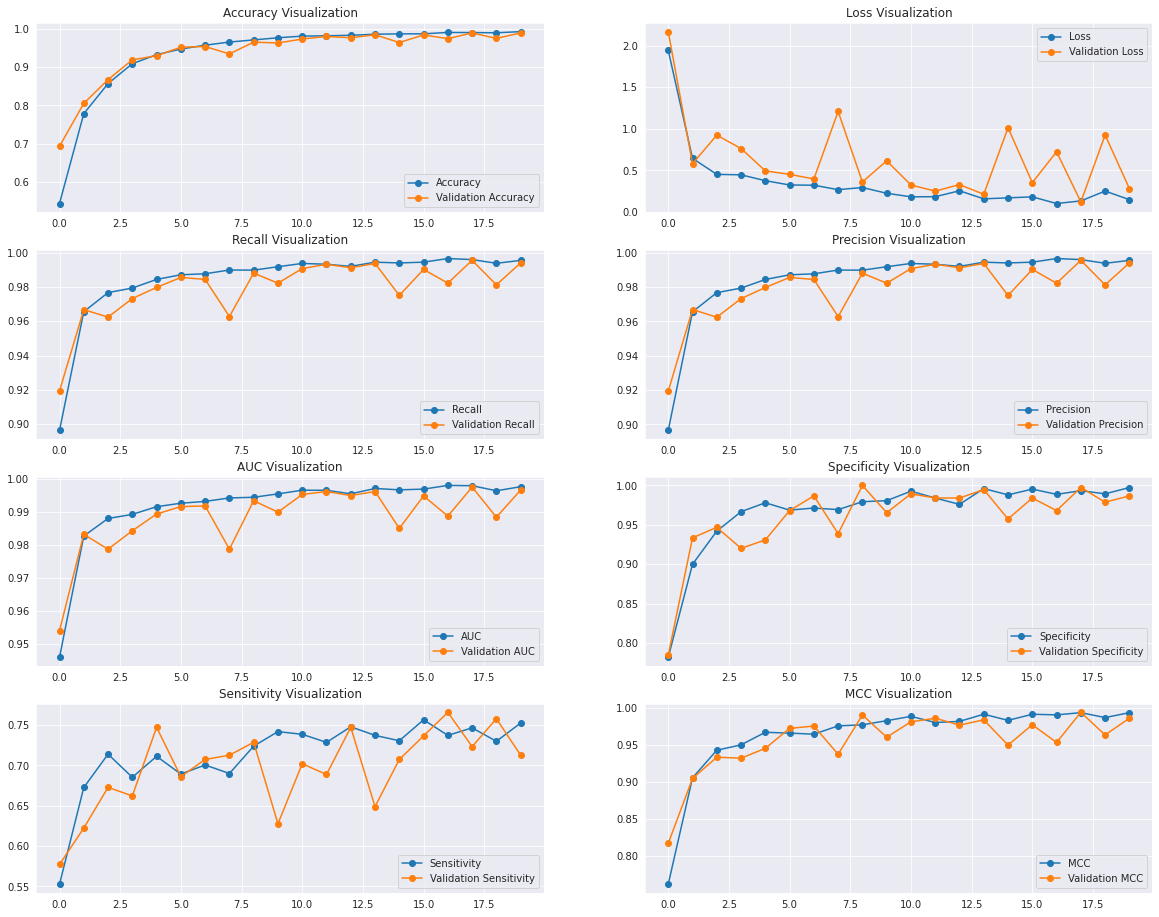

In [ ]:
history_visualization(df)

In [ ]:
final_model_resnet50.save("/content/drive/MyDrive/COVID/resnet_model_best_30k.h5")

In [ ]:
final_model_resnet50.save_weights("/content/drive/MyDrive/COVID/resnet_model_best_30k_weights.h5")

In [ ]:
train_dataset.class_indices

{'COVID': 0, 'Lung opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [ ]:
import pickle 
pickle.dump(train_dataset.class_indices, open('train_dataset.pkl', 'wb'))

In [ ]:
predictions = final_model_resnet50.predict(test_images)

In [ ]:
predictions_index = np.argmax(predictions, axis = -1)

In [ ]:
test_labels_index = np.vectorize(train_dataset.class_indices.get)(test_labels)

In [ ]:
print(classification_report(predictions_index, test_labels_index))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       765
           1       0.94      0.88      0.91      1274
           2       0.89      0.97      0.93      1890
           3       1.00      0.96      0.98       304

    accuracy                           0.93      4233
   macro avg       0.96      0.93      0.94      4233
weighted avg       0.93      0.93      0.93      4233



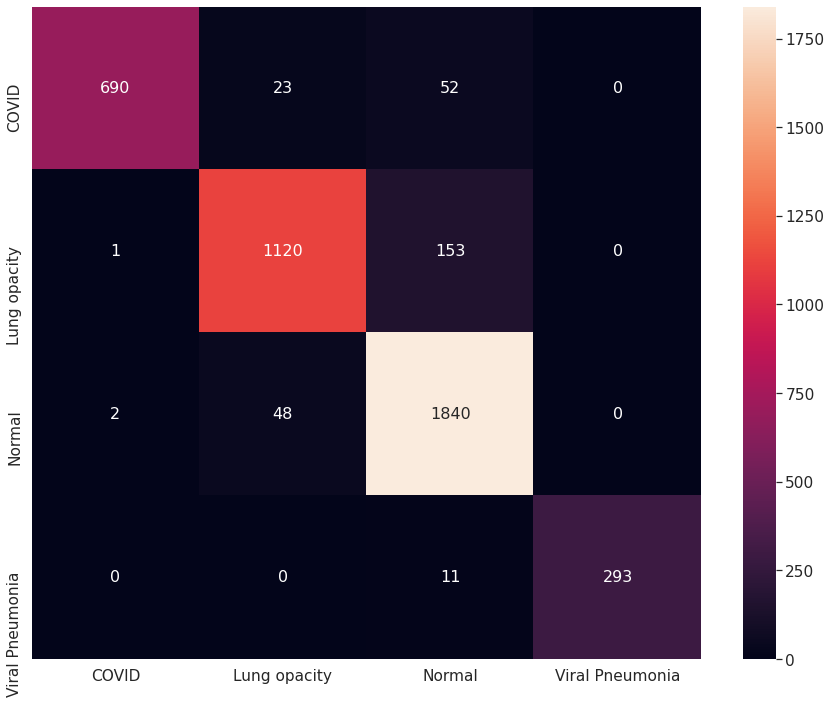

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(predictions_index, test_labels_index)
df_cm = pd.DataFrame(cm, index = [i for i in train_dataset.class_indices],
                  columns = [i for i in train_dataset.class_indices])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()

#ResNet50 with class weights

In [ ]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_dataset.classes), train_dataset.classes)

In [ ]:
train_dataset.class_indices

{'COVID': 0, 'Lung opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [ ]:
class_weights

array([0.85763293, 0.9771987 , 0.91296409, 1.39794967])

In [ ]:
weights = dict(zip([0,1,2,3], class_weights))

In [ ]:
weights

{0: 0.8576329331046312,
 1: 0.9771986970684039,
 2: 0.9129640900791236,
 3: 1.3979496738117427}

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model_resnet50 = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model_resnet50.trainable = False
# base_model_resnet50.summary()
final_model_resnet50 = keras.models.Sequential([base_model_resnet50, keras.layers.Flatten(), keras.layers.Dense(4, activation="softmax")])
final_model_resnet50.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
resnet50_history = final_model_resnet50.fit(x=train_dataset, validation_data=validation_dataset, epochs=20, batch_size=32, callbacks=[early_stoping],  class_weight=weights)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/20
750/750 [==============================] - 8249s 11s/step - loss: 1.8892 - accuracy: 0.5486 - precision: 0.8958 - recall: 0.8955 - auc: 0.9469 - specificity: 0.7740 - sensitivity: 0.5627 - mcc: 0.7716 - val_loss: 1.2777 - val_accuracy: 0.7038 - val_precision: 0.9328 - val_recall: 0.9328 - val_auc: 0.9645 - val_specificity: 0.8059 - val_sensitivity: 0.6862 - val_mcc: 0.8442
Epoch 2/20
750/750 [==============================] - 269s 358ms/step - loss: 0.6546 - accuracy: 0.7850 - precision: 0.9632 - recall: 0.9631 - auc: 0.9811 - specificity: 0.9153 - sensitivity: 0.6947 - mcc: 0.9148 - val_loss: 0.5229 - val_accuracy: 0.8167 - val_precision: 0.9700 - val_recall: 0.9700 - val_auc: 0.9847 - val_specificity: 0.8963 - val_sensitivity: 0.6649 - val_mcc: 0.9003
Epoch 3/20
750/750 [==============================] - 267s 355ms/step - loss: 0.4820 - accuracy: 0.8580 - precision: 0.9741 - recall: 0.9741 - auc: 0.9863 - spe

In [ ]:
df = data(resnet50_history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.548552,0.703818,1.889223,1.277662,0.895500,0.932811,0.895799,0.932811,0.946865,0.964483,0.774000,0.805851,0.562667,0.686170,0.771556,0.844183
1,0.785010,0.816731,0.654631,0.522883,0.963125,0.969990,0.963165,0.969990,0.981114,0.984725,0.915333,0.896277,0.694667,0.664894,0.914752,0.900266
2,0.857958,0.876542,0.481983,0.755022,0.974083,0.965989,0.974083,0.965989,0.986268,0.982944,0.923333,0.896277,0.736000,0.704787,0.931281,0.920213
3,0.902615,0.899592,0.370084,0.427961,0.981958,0.979160,0.981958,0.979160,0.990351,0.988494,0.957333,0.989362,0.728000,0.752659,0.953333,0.957447
4,0.929146,0.933186,0.412525,0.315401,0.982125,0.985662,0.982166,0.985662,0.990192,0.992188,0.968667,0.970745,0.728667,0.704787,0.961032,0.956560
5,0.948635,0.913138,0.296549,1.450863,0.987000,0.952317,0.987000,0.952317,0.993069,0.972143,0.970000,0.930851,0.716000,0.710106,0.973556,0.908245
6,0.955677,0.962904,0.377040,0.331929,0.985625,0.988163,0.985625,0.988163,0.991931,0.993536,0.968000,0.986702,0.704667,0.707447,0.963752,0.988475
7,0.967417,0.961487,0.203340,0.231096,0.992250,0.990330,0.992250,0.990330,0.995611,0.994544,0.983333,0.978723,0.730667,0.702128,0.980156,0.976950
8,0.972573,0.969323,0.291481,0.399676,0.991083,0.988663,0.991083,0.988663,0.995082,0.993097,0.982000,0.981383,0.750667,0.811170,0.980352,0.973404
9,0.973958,0.968740,0.246532,0.273414,0.991583,0.989163,0.991583,0.989163,0.995069,0.993649,0.989333,0.968085,0.738000,0.763298,0.978667,0.974291


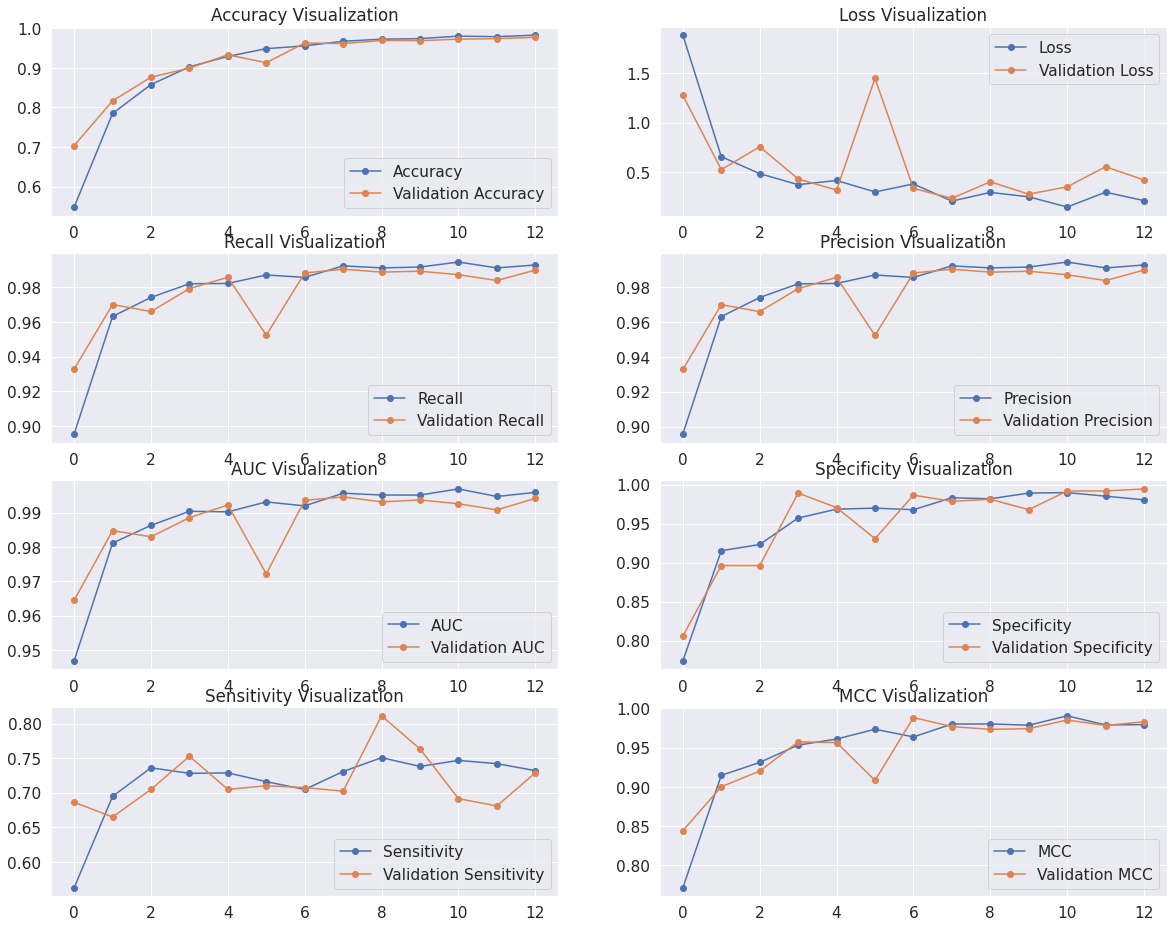

In [ ]:
history_visualization(df)

In [ ]:
final_model_resnet50.save("/content/drive/MyDrive/COVID/resnet_model_best_30k_with_class_weights.h5")

In [ ]:
predictions = final_model_resnet50.predict(test_images)
predictions_index = np.argmax(predictions, axis = -1)
test_labels_index = np.vectorize(train_dataset.class_indices.get)(test_labels)
print(classification_report(predictions_index, test_labels_index))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       802
           1       0.90      0.94      0.92      1138
           2       0.94      0.95      0.95      1985
           3       1.00      0.89      0.94       308

    accuracy                           0.94      4233
   macro avg       0.96      0.93      0.94      4233
weighted avg       0.94      0.94      0.94      4233



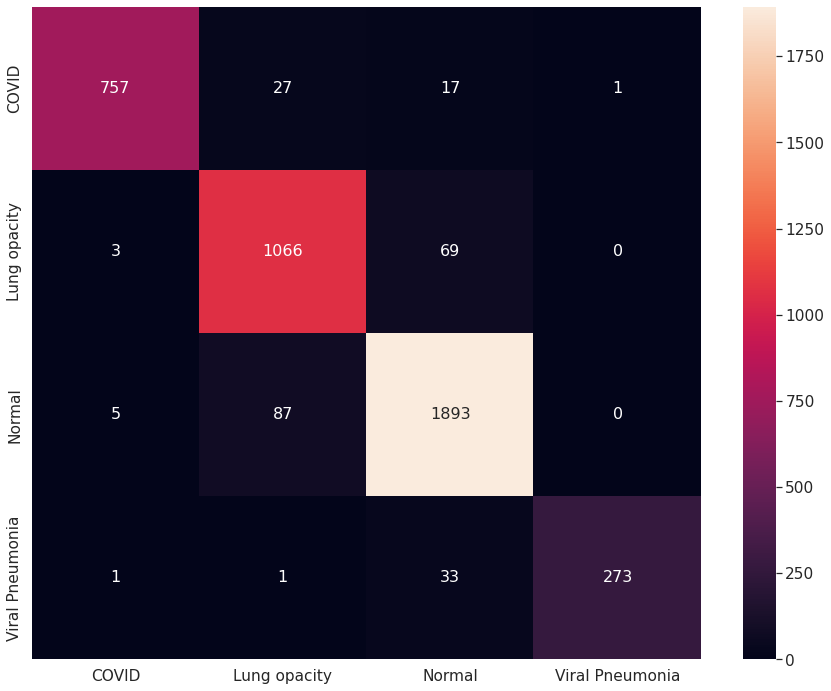

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(predictions_index, test_labels_index)
df_cm = pd.DataFrame(cm, index = [i for i in train_dataset.class_indices],
                  columns = [i for i in train_dataset.class_indices])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()